In [1]:
import time
import utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from six import BytesIO
from PIL import Image

%matplotlib inline

In [2]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 1)).astype(np.uint8)


# Load the Label Map
category_index = {
    1: {'id': 1, 'name': 'Lung Opacity'}
}

In [3]:
saved_model_path = 'pneumonia_detect_faster_rcnn/saved_model/'
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load(saved_model_path)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 33.42237424850464s


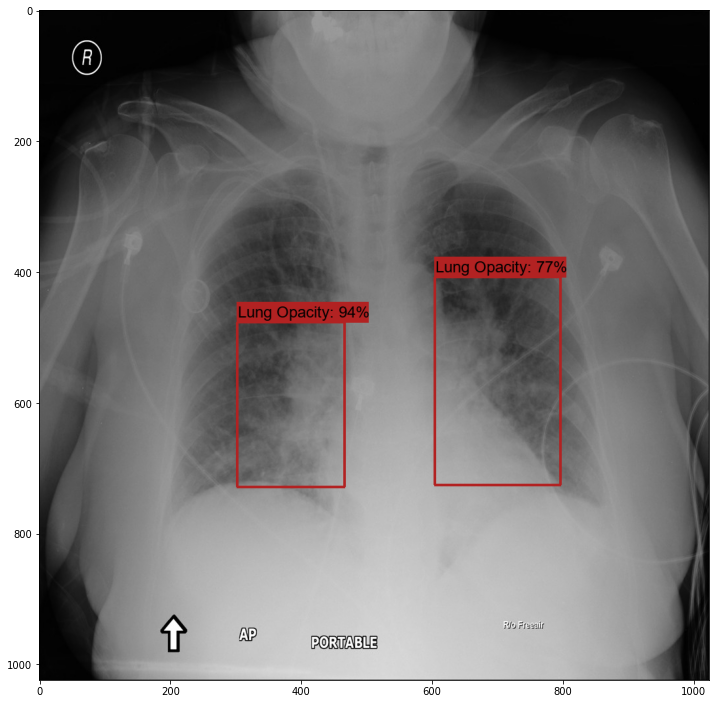

In [4]:
image_path = '020380f8-5c5a-4ded-bdf3-9ce3036945b4.jpg'
image_np = load_image_into_numpy_array(image_path)
stacked_img = np.stack((image_np,)*3, axis=-1)
image_rgb = np.squeeze(stacked_img, axis=2)
input_tensor = np.expand_dims(image_rgb, 0)
start_time = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()


plt.rcParams['figure.figsize'] = [42, 21]
label_id_offset = 1
image_np_with_detections = image_rgb.copy()


# apply non_max_suppression
max_detections_per_class = 100 
max_detections = 100
nms_iou_threshold = 0.1
confidence_threshold = 0.4


non_max = tf.image.combined_non_max_suppression(
            tf.expand_dims(detections['detection_boxes'], axis=2),
            tf.expand_dims(detections['detection_scores'], axis=2),
            max_detections_per_class,
            max_detections,
            nms_iou_threshold,
            confidence_threshold,
            clip_boxes=False)


utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        non_max.nmsed_boxes[0].numpy(),
        (non_max.nmsed_classes[0].numpy().astype(np.int32))+1,
        non_max.nmsed_scores[0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        min_score_thresh=.4,
        agnostic_mode=False)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()